In [1]:
import sys
sys.path.append('../scripts/')
from dp_policy_agent import *

In [2]:
class StateInfo: ###stateinfo2
    def __init__(self, action_num):
        self.q = np.zeros(action_num)
        
    def greedy(self):
        return np.argmax(self.q)
    
    def pi(self):
        return self.greedy()

In [3]:
class QAgent(DpPolicyAgent):  ###qagent2
    def __init__(self, time_interval, estimator, puddle_coef=100, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]): #goalを削除
        super().__init__(time_interval, estimator, None, puddle_coef, widths, lowerleft, upperright) #goalをNoneに
        
        nx, ny, nt = self.index_nums #6-8行目はDynamicProgrammingから持ってくる
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        self.actions = list(set([tuple(self.policy_data[i]) for i in self.indexes]))
        self.ss = self.set_action_value_function() #PuddleIgnorePolicyの方策と価値関数の読み込み

    def set_action_value_function(self): #状態価値関数を読み込んで行動価値関数を初期化
        ss = {} #state spaceという意味
        for line in open("puddle_ignore_values.txt", "r"): #価値のファイルを読み込む
            d = line.split()
            index, value = (int(d[0]), int(d[1]), int(d[2])), float(d[3]) #インデックスをタプル、値を数字に
            ss[index] = StateInfo(len(self.actions)) #StateInfoオブジェクトを割り当てて初期化
            
            for i, a in enumerate(self.actions): #方策の行動価値を価値のファイルに書いてある値に。方策と一致しない行動の場合はちょっと引く
                ss[index].q[i] = value if tuple(self.policy_data[index]) == a else value - 0.1
                
        return ss
    
    def policy(self, pose, goal=None):
        index = self.to_index(pose, self.pose_min, self.index_nums, self.widths)                
        a = self.ss[tuple(index)].pi() #行動価値関数を使って行動決定
        return self.actions[a]

<IPython.core.display.Javascript object>


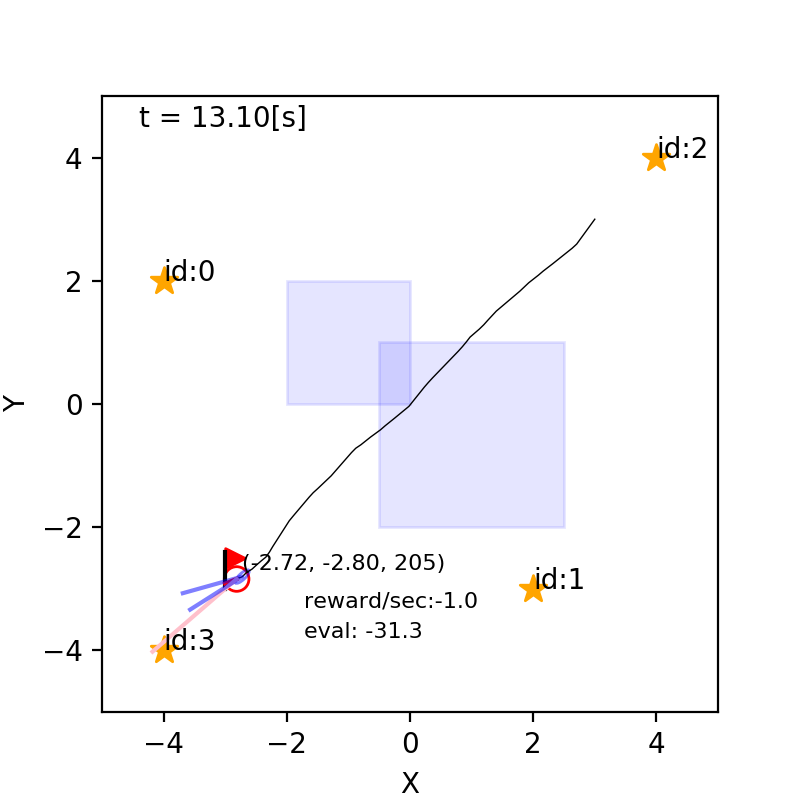

In [4]:
def trial(): 
    time_interval = 0.1
    world = PuddleWorld(400000, time_interval, debug=False)  #長時間アニメーション時間をとる

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3) 
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##ロボットを1台登場させる##
    init_pose = np.array([3, 3, 0]).T
    kf = KalmanFilter(m, init_pose)
    a = QAgent(time_interval, kf) #goalを削除
    r = Robot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))
    world.append(r)
    
    world.draw()
    return a
    
a = trial()